# **Stylizing Images**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from torchvision.datasets import Imagenette
from torch.utils.data import DataLoader, Subset, Dataset
import torchvision
from torchvision.datasets import CIFAR10

import copy
import matplotlib.pyplot as plt
import shutil
import os
from collections import defaultdict

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)
print(device)

cuda


In [3]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

# **Loading Dataset**

### **Task 4: Loading 500 Sampled Images from Imagenette**

In [ ]:
# Set image size based on whether CUDA is available
imsize = 512 if torch.cuda.is_available() else 128

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

content = torchvision.datasets.ImageFolder(root="/kaggle/input/content-imagenette/content_imagenette", transform=transform)
style = torchvision.datasets.ImageFolder(root="/kaggle/input/style-imagenette/style_imagenette", transform=transform)
style_dl = DataLoader(style, batch_size=1, shuffle=True, generator=torch.Generator("cuda"))

content_image = content[0][0]
plt.figure()
imshow(content_image)
plt.show()
content_image = content_image.unsqueeze(0).to(device, torch.float)

style_images, _ = next(iter(style_dl))
style_image = style_images[0]
plt.figure()
imshow(style_image)
plt.show()
style_image = style_image.unsqueeze(0).to(device, torch.float)


input_img = content_image.clone()

### **Run this for Task 5: Sampling 50 Images for each class from CIFAR10**

In [4]:
# sample 50 images from cifar10
transform = transforms.ToTensor()
content = CIFAR10(root="./data", download=True, train=False, transform=transform)

output_dir = "content_cifar10"
os.makedirs(output_dir, exist_ok=True)
class_samples = defaultdict(list)

for idx, (image, label) in enumerate(content):
    class_samples[label].append(image)

samples_per_class = 50

for class_label, images in class_samples.items():
    class_folder = os.path.join(output_dir, f"class_{class_label}")
    os.makedirs(class_folder, exist_ok=True)
    
    for i, img in enumerate(images[:samples_per_class]):
        to_pil = transforms.ToPILImage()
        img_pil = to_pil(img)
        img_pil.save(os.path.join(class_folder, f"image_{i}.png"))

print("Images saved successfully!")
shutil.make_archive("content_cifar10", 'zip', "/kaggle/working/content_cifar10")

100%|██████████| 170498071/170498071 [00:16<00:00, 10058023.75it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Images saved successfully!


'/kaggle/working/content_cifar10.zip'

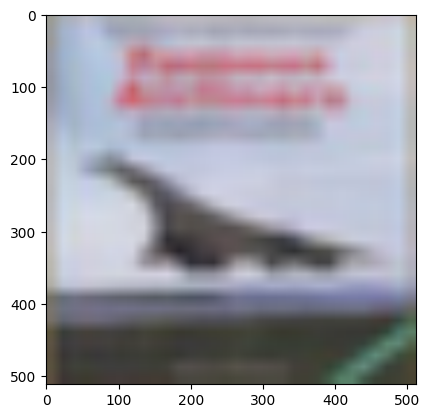

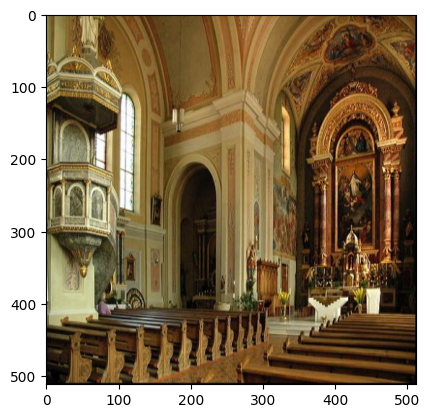

In [5]:
imsize = 512 if torch.cuda.is_available() else 128

# Define the image transformations
transform = transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
])

content = torchvision.datasets.ImageFolder(root="/kaggle/working/content_cifar10", transform=transform)
style = torchvision.datasets.ImageFolder(root="/kaggle/input/style-imagenette/style_imagenette", transform=transform)
style_dl = DataLoader(style, batch_size=1, shuffle=True, generator=torch.Generator("cuda"))

content_image = content[0][0]
plt.figure()
imshow(content_image)
plt.show()
content_image = content_image.unsqueeze(0).to(device, torch.float)

style_images, _ = next(iter(style_dl))
style_image = style_images[0]
plt.figure()
imshow(style_image)
plt.show()
style_image = style_image.unsqueeze(0).to(device, torch.float)


input_img = content_image.clone()

### **Neural Transfer Module**

In [6]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input
    
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input
# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std


def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=10):
    """Run the style transfer."""
    #print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers
    # such as dropout or batch normalization layers behave correctly.
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    #print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            '''if run[0] % 100 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()'''

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:02<00:00, 215MB/s]  
/opt/conda/lib/python3.10/site-packages/torch/utils/_device.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


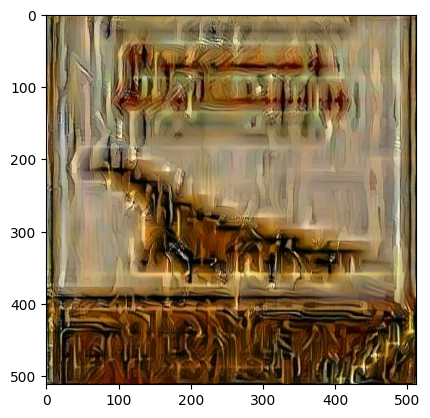

In [7]:
# Demo
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Perform the style transfer (assuming run_style_transfer is defined)
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_image, style_image, input_img)

plt.figure()
imshow(output)
plt.show()

# **Generation of Dataset**

In [8]:
import csv
import os
import random

# Create the main output folder
output_dir = "stylized_cifar10"
os.makedirs(output_dir, exist_ok=True)

# Prepare to save the modified images
modified_images = []
modified_labels = []

# Process images and perform style transfer
for i, (images, labels) in enumerate(content):

    # Set up the VGG19 model for style transfer
    cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval().to(device)
    cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

    # Select content image and random style image, and send them to the GPU (if available)
    content_image = images.unsqueeze(0).to(device, torch.float)
    content_label = content.classes[labels]
    input_img = content_image.clone()

    # Perform the style transfer (assuming run_style_transfer is defined)
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                                content_image, style_image, input_img)

    # Save the generated stylized image
    class_folder = os.path.join(output_dir, content_label)  # Create class-specific folder
    os.makedirs(class_folder, exist_ok=True)

    # Convert the output tensor to an image (PIL format)
    to_pil = transforms.ToPILImage()
    stylized_image = to_pil(output.cpu().squeeze())  # Convert and move to CPU

    # Save the image with a unique filename
    stylized_image.save(os.path.join(class_folder, f"stylized_image_{i}.jpg"))

    # Store the modified images and labels for further use if needed
    modified_images.append(output)
    modified_labels.append(labels)

print("Stylized images and labels saved successfully!")

Stylized images and labels saved successfully!


# **Zipping Dataset**

In [10]:
import shutil
shutil.make_archive("stylized_cifar10", 'zip', "/kaggle/working/stylized_cifar10")

'/kaggle/working/stylized_cifar10.zip'